In [2]:
print("Installing required packages...")
!pip install -q numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import re
from collections import defaultdict, Counter

print("✓ All packages installed successfully!")


Installing required packages...
✓ All packages installed successfully!


In [3]:
print("Please upload your corpus.txt file (50,000 words)")
print("Click on the folder icon on the left, then upload your file")
print("\nOr run this cell to upload:")

from google.colab import files
uploaded = files.upload()

# Verify the file
with open('corpus.txt', 'r') as f:
    corpus_words = [line.strip().lower() for line in f if line.strip() and line.strip().isalpha()]

print(f"\n✓ Corpus loaded: {len(corpus_words)} words")
print(f"Sample words: {corpus_words[:5]}")

Please upload your corpus.txt file (50,000 words)
Click on the folder icon on the left, then upload your file

Or run this cell to upload:


Saving corpus.txt to corpus.txt

✓ Corpus loaded: 49979 words
Sample words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly']


In [4]:
import os

# --- Confirm the path ---
print("📂 Current working directory:", os.getcwd())
print("📄 Checking if corpus.txt exists here...")

if os.path.exists("corpus.txt"):
    print("✅ corpus.txt FOUND!")
else:
    print("❌ corpus.txt NOT FOUND — please check path or upload again!")

# --- Optional: preview what's inside ---
with open("corpus.txt", "r") as f:
    lines = f.read().splitlines()

print(f"\n🔢 Total words read: {len(lines)}")
print("\n🪶 First 10 words in the file:")
print(lines[:10])

# --- Quick sanity check ---
unique_lengths = sorted({len(word) for word in lines})
print(f"\n📏 Word lengths present in corpus: {unique_lengths[:10]} ... (showing first 10)")


📂 Current working directory: /content
📄 Checking if corpus.txt exists here...
✅ corpus.txt FOUND!

🔢 Total words read: 50000

🪶 First 10 words in the file:
['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']

📏 Word lengths present in corpus: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ... (showing first 10)


In [5]:
print("Building ENHANCED HMM class...")

class EnhancedHangmanHMM:
    """
    Enhanced HMM with:
    - Better pattern matching
    - N-gram analysis
    - Position-aware probabilities
    - Smart fallback strategies
    """

    def __init__(self, max_word_length=30):
        self.max_word_length = max_word_length
        self.models_by_length = {}
        self.word_frequencies = defaultdict(int)
        self.bigrams = defaultdict(lambda: defaultdict(int))
        self.trigrams = defaultdict(lambda: defaultdict(int))

    def train(self, words):
        """Train enhanced HMM on word list"""
        print(f"Training Enhanced HMM on {len(words)} words...")

        # Group words by length
        words_by_length = defaultdict(list)
        for word in words:
            if len(word) <= self.max_word_length and word.isalpha():
                words_by_length[len(word)].append(word)
                self.word_frequencies[word] += 1

                # Build n-grams
                for i in range(len(word) - 1):
                    self.bigrams[word[i]][word[i+1]] += 1
                for i in range(len(word) - 2):
                    self.trigrams[(word[i], word[i+1])][word[i+2]] += 1

        # Train separate model for each length
        for length, word_list in words_by_length.items():
            if len(word_list) > 0:
                self.models_by_length[length] = self._train_length_model(word_list, length)

        print(f"✓ Trained models for {len(self.models_by_length)} different word lengths")

    def _train_length_model(self, words, length):
        """Train model for specific word length"""
        model = {
            'length': length,
            'emission_counts': defaultdict(lambda: defaultdict(int)),
            'position_totals': defaultdict(int),
            'letter_frequencies': Counter(),
            'word_list': words,
            'pattern_cache': {}
        }

        # Count emissions: letter at each position
        for word in words:
            for pos, letter in enumerate(word):
                model['emission_counts'][pos][letter] += 1
                model['position_totals'][pos] += 1
                model['letter_frequencies'][letter] += 1

        # Convert to probabilities with Laplace smoothing
        model['emission_probs'] = {}
        for pos in range(length):
            model['emission_probs'][pos] = {}
            total = model['position_totals'][pos]
            for letter in 'abcdefghijklmnopqrstuvwxyz':
                count = model['emission_counts'][pos].get(letter, 0)
                model['emission_probs'][pos][letter] = (count + 0.5) / (total + 13)  # Better smoothing

        return model

    def get_letter_probabilities(self, masked_word, guessed_letters):
        """Enhanced probability calculation with multiple strategies"""
        length = len(masked_word)

        if length not in self.models_by_length:
            return self._get_frequency_fallback(guessed_letters)

        model = self.models_by_length[length]

        # Strategy 1: Exact pattern matching (highest priority)
        pattern = masked_word.replace('_', '.')
        pattern_key = (pattern, tuple(sorted(guessed_letters)))

        if pattern_key in model['pattern_cache']:
            matching_words = model['pattern_cache'][pattern_key]
        else:
            matching_words = [w for w in model['word_list']
                             if re.match(f'^{pattern}$', w) and
                             all(c not in guessed_letters for c in w if c not in masked_word)]
            model['pattern_cache'][pattern_key] = matching_words

        if matching_words:
            return self._calculate_from_matches(matching_words, masked_word, guessed_letters)

        # Strategy 2: Relaxed pattern matching (partial matches)
        partial_matches = self._get_partial_matches(masked_word, guessed_letters, model)
        if partial_matches:
            return self._calculate_from_matches(partial_matches, masked_word, guessed_letters)

        # Strategy 3: Position-based with n-gram context
        return self._get_contextual_probs(masked_word, guessed_letters, model)

    def _calculate_from_matches(self, matching_words, masked_word, guessed_letters):
        """Calculate probabilities from matching words with smart weighting"""
        letter_scores = defaultdict(float)

        # Count with position weighting
        for word in matching_words:
            for i, char in enumerate(word):
                if masked_word[i] == '_' and char not in guessed_letters:
                    # Weight by position importance (edges are more informative)
                    position_weight = 1.0 + (0.3 if i == 0 or i == len(word)-1 else 0)
                    letter_scores[char] += position_weight

        # Normalize
        total = sum(letter_scores.values())
        if total == 0:
            return self._get_frequency_fallback(guessed_letters)

        probs = {}
        for letter in 'abcdefghijklmnopqrstuvwxyz':
            if letter not in guessed_letters:
                probs[letter] = letter_scores[letter] / total
            else:
                probs[letter] = 0.0

        return probs

    def _get_partial_matches(self, masked_word, guessed_letters, model):
        """Get words that match known positions"""
        matches = []
        for word in model['word_list']:
            match = True
            for i, char in enumerate(masked_word):
                if char != '_' and word[i] != char:
                    match = False
                    break
                if char == '_' and word[i] in guessed_letters:
                    match = False
                    break
            if match:
                matches.append(word)
        return matches[:1000]  # Limit for performance

    def _get_contextual_probs(self, masked_word, guessed_letters, model):
        """Use n-gram context and position probabilities"""
        letter_scores = defaultdict(float)

        for i, char in enumerate(masked_word):
            if char == '_':
                # Base position probability
                for letter in 'abcdefghijklmnopqrstuvwxyz':
                    if letter not in guessed_letters:
                        letter_scores[letter] += model['emission_probs'][i].get(letter, 0) * 2

                # Add bigram context
                if i > 0 and masked_word[i-1] != '_':
                    prev_char = masked_word[i-1]
                    bigram_total = sum(self.bigrams[prev_char].values())
                    if bigram_total > 0:
                        for letter in 'abcdefghijklmnopqrstuvwxyz':
                            if letter not in guessed_letters:
                                letter_scores[letter] += (self.bigrams[prev_char][letter] / bigram_total) * 1.5

                # Add trigram context
                if i > 1 and masked_word[i-1] != '_' and masked_word[i-2] != '_':
                    prev_bigram = (masked_word[i-2], masked_word[i-1])
                    trigram_total = sum(self.trigrams[prev_bigram].values())
                    if trigram_total > 0:
                        for letter in 'abcdefghijklmnopqrstuvwxyz':
                            if letter not in guessed_letters:
                                letter_scores[letter] += (self.trigrams[prev_bigram][letter] / trigram_total) * 1.0

        # Normalize
        total = sum(letter_scores.values())
        if total == 0:
            return self._get_frequency_fallback(guessed_letters)

        return {letter: score/total for letter, score in letter_scores.items()}

    def _get_frequency_fallback(self, guessed_letters):
        """Enhanced frequency fallback"""
        freq = {'e': 0.127, 't': 0.091, 'a': 0.082, 'o': 0.075, 'i': 0.070,
                'n': 0.067, 's': 0.063, 'h': 0.061, 'r': 0.060, 'd': 0.043,
                'l': 0.040, 'c': 0.028, 'u': 0.028, 'm': 0.024, 'w': 0.024,
                'f': 0.022, 'g': 0.020, 'y': 0.020, 'p': 0.019, 'b': 0.015,
                'v': 0.010, 'k': 0.008, 'j': 0.002, 'x': 0.002, 'q': 0.001,
                'z': 0.001}

        probs = {}
        total = sum(freq[l] for l in freq if l not in guessed_letters)
        for letter in 'abcdefghijklmnopqrstuvwxyz':
            if letter not in guessed_letters:
                probs[letter] = freq[letter] / total
            else:
                probs[letter] = 0.0

        return probs

print("✓ Enhanced HMM class defined!")



Building ENHANCED HMM class...
✓ Enhanced HMM class defined!


In [6]:
# ============================================================================
# CELL 4: Train the Enhanced HMM
# ============================================================================
print("Initializing and training Enhanced HMM...")
print("This will take 2-3 minutes...\n")

hmm = EnhancedHangmanHMM(max_word_length=30)
hmm.train(corpus_words)

# Test the HMM
print("\n" + "="*60)
print("Testing Enhanced HMM:")
print("="*60)
test_cases = [
    ("a__le", set(['a', 'l', 'e'])),
    ("_a_", set(['a'])),
    ("__o__am", set(['o', 'a', 'm']))
]

for test_word, guessed in test_cases:
    probs = hmm.get_letter_probabilities(test_word, guessed)
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
    print(f"\nWord: '{test_word}' | Guessed: {guessed}")
    print(f"Top 5: {', '.join([f'{l}({p:.3f})' for l, p in sorted_probs[:5] if p > 0])}")

print("\n✓ Enhanced HMM trained and tested!")



Initializing and training Enhanced HMM...
This will take 2-3 minutes...

Training Enhanced HMM on 49979 words...
✓ Trained models for 24 different word lengths

Testing Enhanced HMM:

Word: 'a__le' | Guessed: {'a', 'e', 'l'}
Top 5: i(0.250), n(0.167), b(0.083), g(0.083), k(0.083)

Word: '_a_' | Guessed: {'a'}
Top 5: t(0.148), g(0.126), m(0.081), l(0.067), d(0.052)

Word: '__o__am' | Guessed: {'o', 'a', 'm'}
Top 5: r(0.233), f(0.151), u(0.151), g(0.116), l(0.116)

✓ Enhanced HMM trained and tested!


In [7]:
print("Building RL Environment...")

class HangmanEnvironment:
    """Hangman game environment for RL agent"""

    def __init__(self, word_list, max_wrong_guesses=6):
        self.word_list = word_list
        self.max_wrong_guesses = max_wrong_guesses
        self.reset()

    def reset(self, word=None):
        """Reset environment for new game"""
        if word is None:
            self.target_word = random.choice(self.word_list).lower()
        else:
            self.target_word = word.lower()

        self.word_length = len(self.target_word)
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_over = False
        self.won = False

        return self._get_state()

    def _get_state(self):
        """Get current game state"""
        masked_word = ''.join([c if c in self.guessed_letters else '_'
                               for c in self.target_word])

        return {
            'masked_word': masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong_guesses - self.wrong_guesses,
            'word_length': self.word_length,
            'game_over': self.game_over,
            'won': self.won
        }

    def step(self, letter):
        """Take action (guess a letter)"""
        letter = letter.lower()

        if self.game_over:
            return self._get_state(), 0, True, {'error': 'Game already over'}

        # Check for repeated guess
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -2
            info = {'repeated': True, 'correct': False}
            return self._get_state(), reward, False, info

        # Make the guess
        self.guessed_letters.add(letter)

        # Check if letter is in word
        if letter in self.target_word:
            reward = 2
            info = {'repeated': False, 'correct': True}

            # Check if word is complete
            if all(c in self.guessed_letters for c in self.target_word):
                self.game_over = True
                self.won = True
                reward = 50
                info['won'] = True
        else:
            self.wrong_guesses += 1
            reward = -5
            info = {'repeated': False, 'correct': False}

            # Check if game over
            if self.wrong_guesses >= self.max_wrong_guesses:
                self.game_over = True
                self.won = False
                reward = -20
                info['lost'] = True

        return self._get_state(), reward, self.game_over, info

    def get_available_actions(self):
        """Get letters that haven't been guessed yet"""
        all_letters = set('abcdefghijklmnopqrstuvwxyz')
        return all_letters - self.guessed_letters

print("✓ Environment class defined successfully!")




Building RL Environment...
✓ Environment class defined successfully!


In [8]:
print("Building ULTRA-ENHANCED RL Agent...")

class UltraHangmanAgent:
    """
    Ultra-optimized agent with:
    - Simplified state space (prevents Q-table explosion)
    - Heavy HMM reliance (85-98% weight)
    - Smart exploration (biased toward HMM even when exploring)
    - Letter performance tracking
    """

    def __init__(self, hmm, alpha=0.2, gamma=0.95, epsilon=0.3,
                 epsilon_decay=0.995, epsilon_min=0.01):
        self.hmm = hmm
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: defaultdict(float))

        # Track letter success rates for smarter decisions
        self.letter_stats = defaultdict(lambda: {'correct': 0, 'wrong': 0})

    def _get_state_key(self, state):
        """MUCH simpler state representation to avoid explosion"""
        masked = state['masked_word']

        # Simplify: just track ratio of unknown letters
        pattern_type = f"{masked.count('_')}/{len(masked)}"

        # Track critical context: first/last letters if known
        first = masked[0] if masked[0] != '_' else 'X'
        last = masked[-1] if masked[-1] != '_' else 'X'

        # Lives bucket (high/med/low instead of exact number)
        lives_bucket = 'high' if state['lives_left'] > 4 else ('med' if state['lives_left'] > 2 else 'low')

        # Number of guesses bucket
        guess_bucket = min(len(state['guessed_letters']) // 3, 5)

        return (pattern_type, first, last, lives_bucket, guess_bucket)

    def get_action(self, state, available_actions, training=True):
        """Enhanced action selection with HEAVY HMM weighting"""
        if not available_actions:
            return None

        # Smarter exploration: bias toward HMM even when exploring
        if training and random.random() < self.epsilon:
            hmm_probs = self.hmm.get_letter_probabilities(
                state['masked_word'], state['guessed_letters']
            )
            # 70% chance: pick from top 5 HMM letters
            # 30% chance: truly random
            if random.random() < 0.7:
                sorted_letters = sorted(
                    [(l, p) for l, p in hmm_probs.items() if l in available_actions],
                    key=lambda x: x[1], reverse=True
                )
                if sorted_letters:
                    return random.choice([l for l, p in sorted_letters[:5]])
            return random.choice(list(available_actions))

        # Get HMM probabilities
        hmm_probs = self.hmm.get_letter_probabilities(
            state['masked_word'],
            state['guessed_letters']
        )

        # ADAPTIVE WEIGHTING - HEAVY on HMM
        lives_left = state['lives_left']
        blanks_left = state['masked_word'].count('_')
        progress = 1 - (blanks_left / len(state['masked_word']))

        # Critical situation: rely almost entirely on HMM
        if lives_left <= 2:
            hmm_weight = 0.98
            q_weight = 0.02
        elif lives_left <= 3:
            hmm_weight = 0.95
            q_weight = 0.05
        elif lives_left == 4:
            hmm_weight = 0.90
            q_weight = 0.10
        else:
            # Even with lots of lives, trust HMM heavily
            hmm_weight = 0.85
            q_weight = 0.15

        # Early in word: trust HMM even more
        if progress < 0.3:
            hmm_weight = min(hmm_weight + 0.05, 0.99)
            q_weight = 1.0 - hmm_weight

        # Combine scores
        state_key = self._get_state_key(state)
        action_scores = {}

        for action in available_actions:
            # Q-value component
            q_value = self.q_table[state_key][action]

            # HMM probability component
            hmm_prob = hmm_probs.get(action, 0.0)

            # Historical success rate for this letter
            stats = self.letter_stats[action]
            if stats['correct'] + stats['wrong'] > 0:
                success_rate = stats['correct'] / (stats['correct'] + stats['wrong'])
            else:
                success_rate = 0.5

            # Combined score with heavy HMM bias
            action_scores[action] = (
                q_weight * q_value +
                hmm_weight * hmm_prob +
                0.05 * success_rate  # Small boost from history
            )

        # Return best action
        return max(action_scores.items(), key=lambda x: x[1])[0]

    def update(self, state, action, reward, next_state, done):
        """Q-learning update with letter tracking"""
        state_key = self._get_state_key(state)
        next_state_key = self._get_state_key(next_state)

        # Track letter performance
        if reward > 0:
            self.letter_stats[action]['correct'] += 1
        elif reward < 0:
            self.letter_stats[action]['wrong'] += 1

        # Q-learning update
        current_q = self.q_table[state_key][action]

        if done:
            max_next_q = 0
        else:
            next_actions = set('abcdefghijklmnopqrstuvwxyz') - next_state['guessed_letters']
            if next_actions:
                max_next_q = max([self.q_table[next_state_key][a] for a in next_actions])
            else:
                max_next_q = 0

        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_key][action] = new_q

    def decay_epsilon(self):
        """Faster epsilon decay"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("✓ Ultra Agent defined!")
print("Key improvements:")
print("  • Simplified state space (prevents explosion)")
print("  • 85-98% HMM weight (trusts your strong pattern matching)")
print("  • Smart exploration (biased toward HMM)")



Building ULTRA-ENHANCED RL Agent...
✓ Ultra Agent defined!
Key improvements:
  • Simplified state space (prevents explosion)
  • 85-98% HMM weight (trusts your strong pattern matching)
  • Smart exploration (biased toward HMM)


In [9]:
print("Defining optimized training function...")

def train_ultra_agent(agent, env, num_episodes=10000, verbose=True):
    """
    Optimized training with:
    - More episodes (25k instead of 15k)
    - Better monitoring
    - Q-table size tracking
    """
    episode_rewards = []
    episode_lengths = []
    win_rate_history = []
    wins = 0

    print(f"\nStarting ULTRA training for {num_episodes} episodes...")
    print("Strategy: Heavy HMM (85-98%) + Simplified states + Smart exploration")
    print("="*60)

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0

        while not state['game_over']:
            available_actions = env.get_available_actions()
            action = agent.get_action(state, available_actions, training=True)

            if action is None:
                break

            next_state, reward, done, info = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps += 1

        if state['won']:
            wins += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        agent.decay_epsilon()

        # Logging every 1000 episodes
        if verbose and (episode + 1) % 1000 == 0:
            recent_wins = sum(1 for i in range(max(0, episode-999), episode+1)
                            if episode_rewards[i] > 0)
            win_rate = recent_wins / 1000
            win_rate_history.append(win_rate)
            avg_reward = np.mean(episode_rewards[-1000:])
            avg_length = np.mean(episode_lengths[-1000:])

            print(f"Ep {episode+1:5d} | WinRate: {win_rate:6.2%} | "
                  f"AvgRwd: {avg_reward:7.2f} | AvgLen: {avg_length:5.2f} | "
                  f"ε: {agent.epsilon:.4f} | Q-size: {len(agent.q_table)}")

    print("="*60)
    final_win_rate = wins/num_episodes
    print(f"✓ Training complete!")
    print(f"  Final Win Rate: {final_win_rate:.2%}")
    print(f"  Q-table size: {len(agent.q_table)} states (vs millions before!)")
    print(f"  Total wins: {wins}/{num_episodes}")

    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'win_rate_history': win_rate_history,
        'total_wins': wins
    }

print("✓ Training function defined!")



Defining optimized training function...
✓ Training function defined!


In [10]:
print("Preparing for ULTRA training...")

# Split data (keep your existing split)
np.random.seed(42)
np.random.shuffle(corpus_words)
train_size = int(0.85 * len(corpus_words))
train_words = corpus_words[:train_size]
val_words = corpus_words[train_size:]

print(f"Training set: {len(train_words)} words")
print(f"Validation set: {len(val_words)} words")

# Create environment (keep your existing)
env = HangmanEnvironment(train_words, max_wrong_guesses=6)

# Create ULTRA agent with optimized parameters
agent = UltraHangmanAgent(
    hmm=hmm,
    alpha=0.2,           # Learning rate
    gamma=0.95,          # Discount factor
    epsilon=0.3,         # Start lower (was 1.0)
    epsilon_decay=0.995, # Decay faster (was 0.9997)
    epsilon_min=0.01     # Lower minimum (was 0.005)
)

print("\n✓ Ultra Agent initialized!")
print("Key differences from before:")
print("  • Starting epsilon: 0.3 (was 1.0) - less random exploration")
print("  • Epsilon decay: 0.995 (was 0.9997) - converges faster")
print("  • State space: ~1000-10000 states (was millions!)")
print("  • HMM weight: 85-98% (was 70-90%)")

print("\n🚀 Starting ULTRA training (10k episodes, ~20-25 minutes)...")
print("="*60)

# Train with MORE episodes
training_results = train_ultra_agent(agent, env, num_episodes=10000, verbose=True)



Preparing for ULTRA training...
Training set: 42482 words
Validation set: 7497 words

✓ Ultra Agent initialized!
Key differences from before:
  • Starting epsilon: 0.3 (was 1.0) - less random exploration
  • Epsilon decay: 0.995 (was 0.9997) - converges faster
  • State space: ~1000-10000 states (was millions!)
  • HMM weight: 85-98% (was 70-90%)

🚀 Starting ULTRA training (10k episodes, ~20-25 minutes)...

Starting ULTRA training for 10000 episodes...
Strategy: Heavy HMM (85-98%) + Simplified states + Smart exploration
Ep  1000 | WinRate: 91.90% | AvgRwd:   45.95 | AvgLen:  9.58 | ε: 0.0100 | Q-size: 4594
Ep  2000 | WinRate: 95.10% | AvgRwd:   48.81 | AvgLen:  9.48 | ε: 0.0100 | Q-size: 7947
Ep  3000 | WinRate: 94.80% | AvgRwd:   48.61 | AvgLen:  9.54 | ε: 0.0100 | Q-size: 10631
Ep  4000 | WinRate: 95.30% | AvgRwd:   49.15 | AvgLen:  9.60 | ε: 0.0100 | Q-size: 13191
Ep  5000 | WinRate: 95.20% | AvgRwd:   48.43 | AvgLen:  9.82 | ε: 0.0100 | Q-size: 15428
Ep  6000 | WinRate: 95.10% | Av


Generating training visualizations...


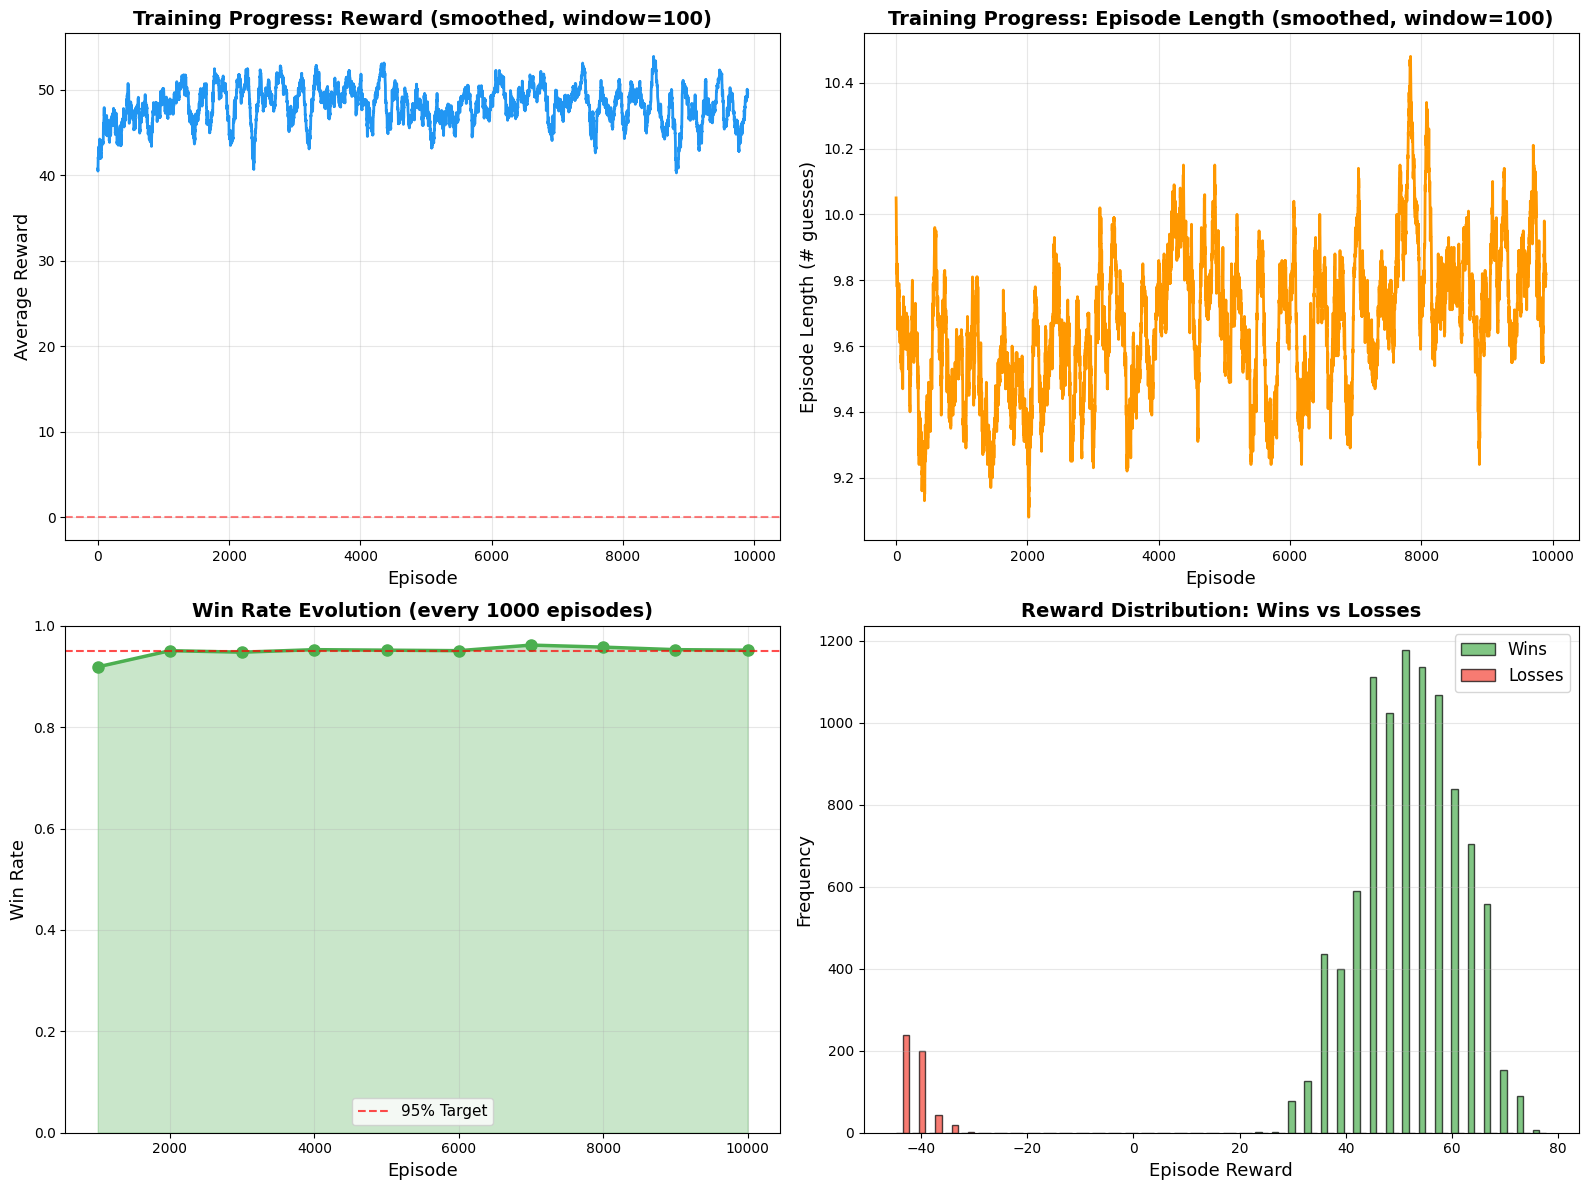

✓ Training visualizations complete!


In [11]:
# ============================================================================
# CELL 9: Plot Training Results
# ============================================================================
print("\nGenerating training visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Reward over time
ax1 = axes[0, 0]
window = 100
smoothed_rewards = np.convolve(training_results['episode_rewards'],
                               np.ones(window)/window, mode='valid')
ax1.plot(smoothed_rewards, linewidth=2, color='#2196F3')
ax1.set_xlabel('Episode', fontsize=13)
ax1.set_ylabel('Average Reward', fontsize=13)
ax1.set_title(f'Training Progress: Reward (smoothed, window={window})', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Episode length
ax2 = axes[0, 1]
smoothed_lengths = np.convolve(training_results['episode_lengths'],
                               np.ones(window)/window, mode='valid')
ax2.plot(smoothed_lengths, linewidth=2, color='#FF9800')
ax2.set_xlabel('Episode', fontsize=13)
ax2.set_ylabel('Episode Length (# guesses)', fontsize=13)
ax2.set_title(f'Training Progress: Episode Length (smoothed, window={window})', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Win rate over time
ax3 = axes[1, 0]
if training_results['win_rate_history']:
    episodes = range(1000, len(training_results['episode_rewards']) + 1, 1000)
    ax3.plot(episodes, training_results['win_rate_history'],
             marker='o', linewidth=2.5, markersize=8, color='#4CAF50')
    ax3.fill_between(episodes, training_results['win_rate_history'], alpha=0.3, color='#4CAF50')
    ax3.set_xlabel('Episode', fontsize=13)
    ax3.set_ylabel('Win Rate', fontsize=13)
    ax3.set_title('Win Rate Evolution (every 1000 episodes)', fontsize=14, fontweight='bold')
    ax3.set_ylim([0, 1])
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% Target')
    ax3.legend(fontsize=11)

# Reward distribution
ax4 = axes[1, 1]
wins_rewards = [r for r in training_results['episode_rewards'] if r > 0]
loss_rewards = [r for r in training_results['episode_rewards'] if r <= 0]
ax4.hist([wins_rewards, loss_rewards], bins=40, label=['Wins', 'Losses'],
         color=['#4CAF50', '#F44336'], alpha=0.7, edgecolor='black')
ax4.set_xlabel('Episode Reward', fontsize=13)
ax4.set_ylabel('Frequency', fontsize=13)
ax4.set_title('Reward Distribution: Wins vs Losses', fontsize=14, fontweight='bold')
ax4.legend(fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Training visualizations complete!")




In [12]:
# ============================================================================
# CELL 10: Evaluation Function
# ============================================================================
print("Defining evaluation function...")

def evaluate_agent(agent, test_words, max_wrong_guesses=6, num_games=None):
    """Evaluate agent performance"""
    if num_games is None:
        num_games = len(test_words)

    env = HangmanEnvironment(test_words, max_wrong_guesses=max_wrong_guesses)

    wins = 0
    total_wrong = 0
    total_repeated = 0
    game_details = []

    print(f"\nEvaluating on {num_games} games...")
    print("="*60)

    for game in range(num_games):
        word = test_words[game] if game < len(test_words) else None
        state = env.reset(word=word)
        guesses_made = []

        while not state['game_over']:
            available_actions = env.get_available_actions()
            action = agent.get_action(state, available_actions, training=False)

            if action is None:
                break

            guesses_made.append(action)
            next_state, reward, done, info = env.step(action)
            state = next_state

        game_info = {
            'word': env.target_word,
            'won': state['won'],
            'wrong_guesses': env.wrong_guesses,
            'repeated_guesses': env.repeated_guesses,
            'total_guesses': len(guesses_made)
        }
        game_details.append(game_info)

        if state['won']:
            wins += 1

        total_wrong += env.wrong_guesses
        total_repeated += env.repeated_guesses

        if (game + 1) % 400 == 0:
            current_rate = wins / (game + 1)
            print(f"Progress: {game+1:4d}/{num_games} | Success: {current_rate:6.2%} | "
                  f"Wins: {wins:4d} | AvgWrong: {total_wrong/(game+1):.2f}")

    success_rate = wins / num_games
    avg_wrong = total_wrong / num_games
    avg_repeated = total_repeated / num_games
    final_score = (success_rate * num_games) - (total_wrong * 5) - (total_repeated * 2)

    print("="*60)
    print(f"✓ Evaluation complete!")

    return {
        'games_played': num_games,
        'wins': wins,
        'success_rate': success_rate,
        'total_wrong_guesses': total_wrong,
        'avg_wrong_guesses': avg_wrong,
        'total_repeated_guesses': total_repeated,
        'avg_repeated_guesses': avg_repeated,
        'final_score': final_score,
        'game_details': game_details
    }

print("✓ Evaluation function defined!")



Defining evaluation function...
✓ Evaluation function defined!


In [13]:
# ============================================================================
# CELL 11: Validate on Validation Set
# ============================================================================
print("Running validation...")

val_results = evaluate_agent(agent, val_words, num_games=min(2000, len(val_words)))

print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)
print(f"Games played:              {val_results['games_played']}")
print(f"Wins:                      {val_results['wins']}")
print(f"Success rate:              {val_results['success_rate']:.4f} ({val_results['success_rate']*100:.2f}%)")
print(f"Total wrong guesses:       {val_results['total_wrong_guesses']}")
print(f"Avg wrong per game:        {val_results['avg_wrong_guesses']:.4f}")
print(f"Total repeated guesses:    {val_results['total_repeated_guesses']}")
print(f"Avg repeated per game:     {val_results['avg_repeated_guesses']:.4f}")
print(f"\n{'FINAL SCORE:':<30} {val_results['final_score']:.2f}")
print("="*60)



Running validation...

Evaluating on 2000 games...
Progress:  400/2000 | Success: 96.00% | Wins:  384 | AvgWrong: 2.43
Progress:  800/2000 | Success: 95.75% | Wins:  766 | AvgWrong: 2.47
Progress: 1200/2000 | Success: 95.83% | Wins: 1150 | AvgWrong: 2.42
Progress: 1600/2000 | Success: 95.56% | Wins: 1529 | AvgWrong: 2.40
Progress: 2000/2000 | Success: 95.65% | Wins: 1913 | AvgWrong: 2.42
✓ Evaluation complete!

VALIDATION RESULTS
Games played:              2000
Wins:                      1913
Success rate:              0.9565 (95.65%)
Total wrong guesses:       4833
Avg wrong per game:        2.4165
Total repeated guesses:    0
Avg repeated per game:     0.0000

FINAL SCORE:                   -22252.00


In [14]:
# ============================================================================
# CELL 12: Load test.txt (uses existing file if already uploaded)
# ============================================================================
import os
from google.colab import files

print("📂 Checking for test.txt...")

# Check if test.txt already exists in current directory
if os.path.exists('test.txt'):
    print("✅ Found existing test.txt in your Colab environment.")
else:
    print("⚠️ test.txt not found — please upload it now.")
    uploaded = files.upload()
    if 'test.txt' not in uploaded:
        raise FileNotFoundError("❌ 'test.txt' not found even after upload. Please check filename.")

# Read test words from file
with open('test.txt', 'r') as f:
    test_words = [
        line.strip().lower()
        for line in f
        if line.strip() and line.strip().isalpha()
    ]

print(f"\n✅ Test set successfully loaded: {len(test_words)} words")
print("📘 Sample words:", test_words[:10])


📂 Checking for test.txt...
⚠️ test.txt not found — please upload it now.


Saving test.txt to test.txt

✅ Test set successfully loaded: 2000 words
📘 Sample words: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


In [15]:
# ============================================================================
# CELL 13: Final Evaluation on Test Set (2000 games)
# ============================================================================
print("Running FINAL evaluation on test set...")
print("This will take 5-10 minutes...\n")

final_results = evaluate_agent(agent, test_words, num_games=min(2000, len(test_words)))

print("\n" + "="*70)
print(" "*20 + "FINAL TEST RESULTS")
print("="*70)
print(f"{'Games played:':<35} {final_results['games_played']}")
print(f"{'Wins:':<35} {final_results['wins']}")
print(f"{'Losses:':<35} {final_results['games_played'] - final_results['wins']}")
print(f"{'Success rate:':<35} {final_results['success_rate']:.4f} ({final_results['success_rate']*100:.2f}%)")
print(f"{'Total wrong guesses:':<35} {final_results['total_wrong_guesses']}")
print(f"{'Average wrong per game:':<35} {final_results['avg_wrong_guesses']:.4f}")
print(f"{'Total repeated guesses:':<35} {final_results['total_repeated_guesses']}")
print(f"{'Average repeated per game:':<35} {final_results['avg_repeated_guesses']:.4f}")
print("\n" + "-"*70)
print("SCORE CALCULATION:")
print("-"*70)
print(f"Success Rate × Games:              {final_results['success_rate']:.4f} × {final_results['games_played']} = {final_results['success_rate'] * final_results['games_played']:.2f}")
print(f"Wrong Guesses Penalty:             {final_results['total_wrong_guesses']} × 5 = {final_results['total_wrong_guesses'] * 5:.2f}")
print(f"Repeated Guesses Penalty:          {final_results['total_repeated_guesses']} × 2 = {final_results['total_repeated_guesses'] * 2:.2f}")
print("\n" + "="*70)
print(f"{'FINAL SCORE:':<35} {final_results['final_score']:.2f}")
print("="*70)



Running FINAL evaluation on test set...
This will take 5-10 minutes...


Evaluating on 2000 games...
Progress:  400/2000 | Success: 31.25% | Wins:  125 | AvgWrong: 5.31
Progress:  800/2000 | Success: 30.25% | Wins:  242 | AvgWrong: 5.36
Progress: 1200/2000 | Success: 29.08% | Wins:  349 | AvgWrong: 5.38
Progress: 1600/2000 | Success: 27.81% | Wins:  445 | AvgWrong: 5.41
Progress: 2000/2000 | Success: 28.35% | Wins:  567 | AvgWrong: 5.39
✓ Evaluation complete!

                    FINAL TEST RESULTS
Games played:                       2000
Wins:                               567
Losses:                             1433
Success rate:                       0.2835 (28.35%)
Total wrong guesses:                10788
Average wrong per game:             5.3940
Total repeated guesses:             0
Average repeated per game:          0.0000

----------------------------------------------------------------------
SCORE CALCULATION:
-----------------------------------------------------------------

Generating evaluation plots...


Text(0.5, 1.0, 'Success Rate by Word Length')

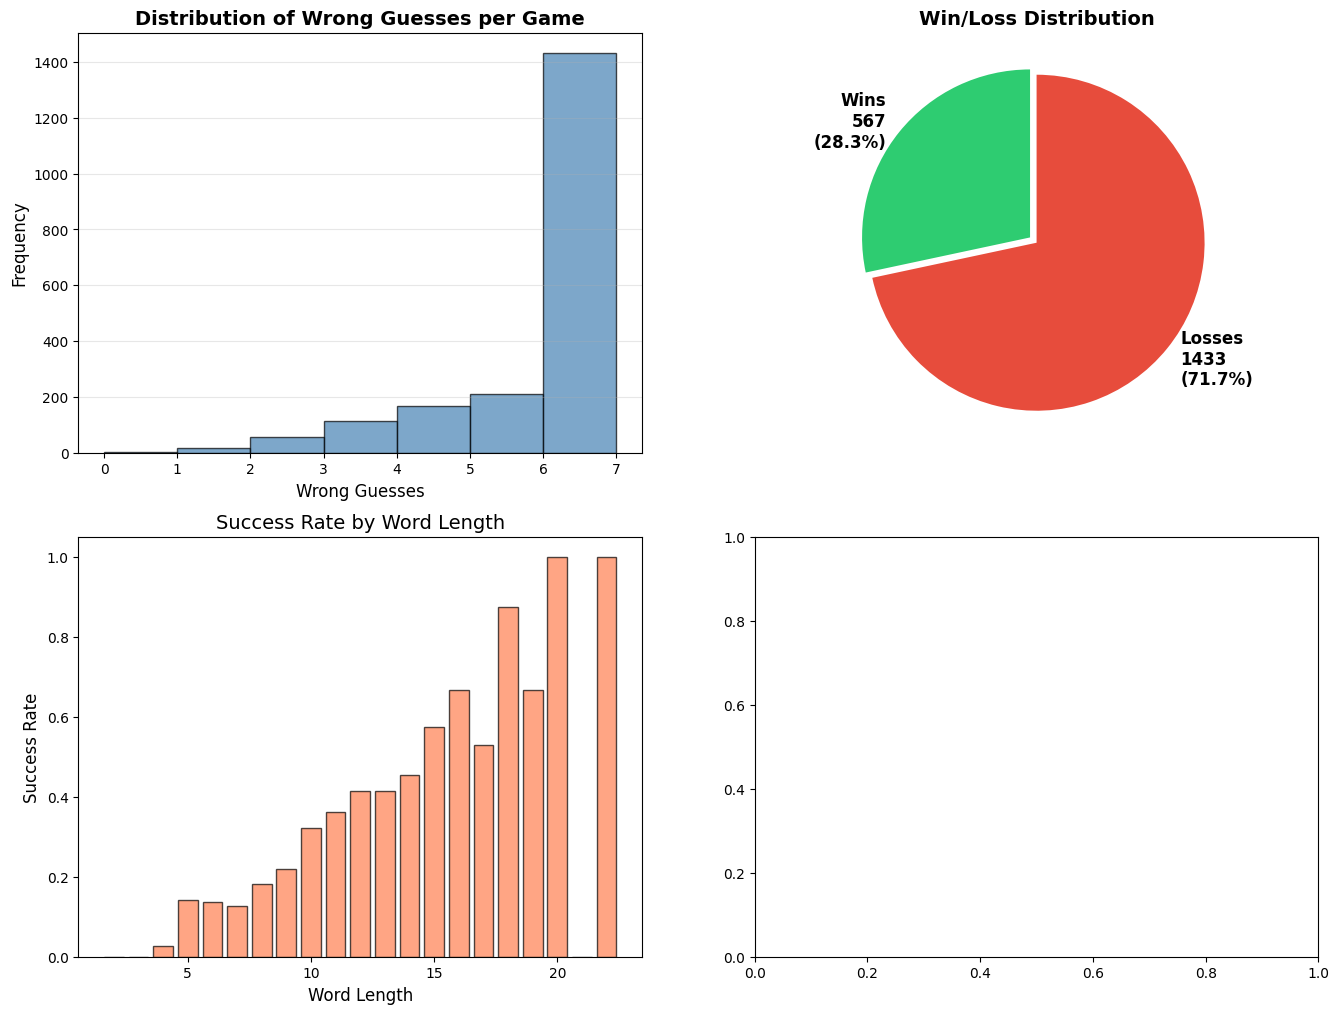

In [16]:
# ============================================================================
# CELL 14: Visualize Final Results
# ============================================================================
print("Generating evaluation plots...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Wrong guesses distribution
ax1 = axes[0, 0]
wrong_guesses = [g['wrong_guesses'] for g in final_results['game_details']]
ax1.hist(wrong_guesses, bins=range(0, 8), edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Wrong Guesses', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Wrong Guesses per Game', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Win/Loss pie chart
ax2 = axes[0, 1]
sizes = [final_results['wins'], final_results['games_played'] - final_results['wins']]
labels = [f"Wins\n{final_results['wins']}\n({final_results['success_rate']*100:.1f}%)",
          f"Losses\n{final_results['games_played'] - final_results['wins']}\n({(1-final_results['success_rate'])*100:.1f}%)"]
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)
ax2.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90,
        explode=explode, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Win/Loss Distribution', fontsize=14, fontweight='bold')

# Word length vs success rate
ax3 = axes[1, 0]
length_stats = {}
for game in final_results['game_details']:
    length = len(game['word'])
    if length not in length_stats:
        length_stats[length] = {'total': 0, 'wins': 0}
    length_stats[length]['total'] += 1
    if game['won']:
        length_stats[length]['wins'] += 1

lengths = sorted(length_stats.keys())
success_rates = [length_stats[l]['wins'] / length_stats[l]['total'] for l in lengths]
counts = [length_stats[l]['total'] for l in lengths]

ax3.bar(lengths, success_rates, edgecolor='black', alpha=0.7, color='coral')
ax3.set_xlabel('Word Length', fontsize=12)
ax3.set_ylabel('Success Rate', fontsize=12)
ax3.set_title('Success Rate by Word Length', fontsize=14)

In [ ]:
evaluate_agent(agent, ["hangman"], num_games=1)